In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import random
import math
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from pyproteonet.data import Dataset

eval_columns = ['mindet', 'minprob', 'mean', 'knn', 'missforest', 'bpca', 'isvd', 'vae', 'dae', 'cf', 'iterative', 'gnn_imp']

# Load Datasets

In [35]:
from preprocessing import embed_sequences_t5_cached, create_masked_dataset, remove_all_missing
imp_datasets = {}

for ds_name in ['maxlfqbench']:
    print(ds_name)
    ds = Dataset.load(f'data/datasets_imputed/{ds_name}')
    imp_datasets[ds_name] = ds

maxlfqbench


In [36]:
from pyproteonet.metrics.abundance_comparison import compare_columns
from matplotlib import pyplot as plt
import seaborn as sns
from seaborn import boxplot

from pyproteonet.metrics.paired_testing import paired_wilcoxon_matrix

/tmp/ipykernel_857523/2469375740.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_857523/2469375740.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_857523/2469375740.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mae.index, rotation=45, ha='right')


  0%|          | 0/132 [00:00<?, ?it/s]

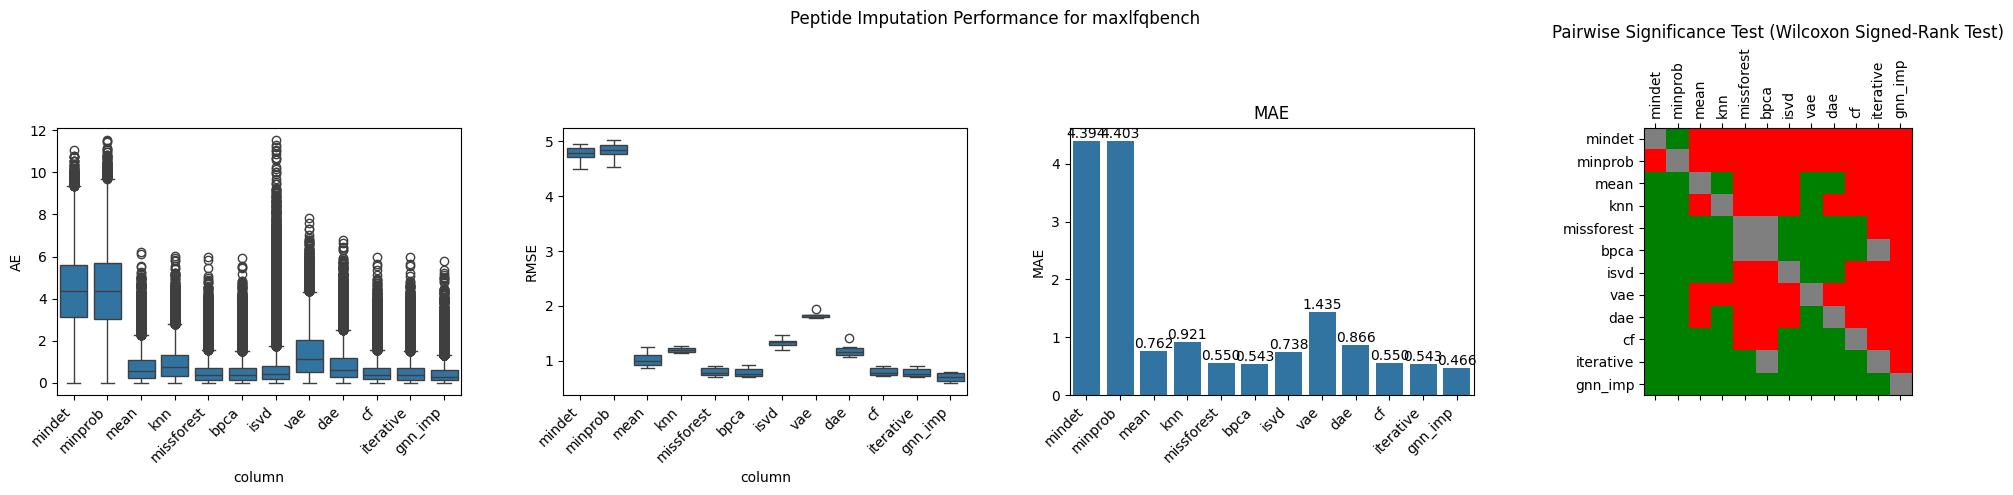

In [37]:
for ds_name, ds in imp_datasets.items():
    not_all_missing = ds.get_wf('peptide', 'abundance')
    not_all_missing = not_all_missing[not_all_missing.count(axis=1) > 0].index
    gt_column = 'abundance_gt'
    ids = ds.values['peptide'][gt_column]
    ids = ids[~ids.isna() & ds.values['peptide']['abundance'].isna()].index
    ids = ids[ids.get_level_values('id').isin(not_all_missing)]
    df= ds.values['peptide'].df.loc[ids, eval_columns]
    df = df[~df.isna().any(axis=1)]
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs = axs.flatten()
    # molecule AE and sample wise RMSE plots
    fig.suptitle(f'Peptide Imputation Performance for {ds_name}')
    for metric, ax in zip(['AE', 'RMSE'], axs):
        metric_df = compare_columns(dataset=ds, molecule='peptide', columns=eval_columns, comparison_column=gt_column,
                                    metric=metric, logarithmize=False, ids=ids, per_sample=True, ignore_missing=False)
        boxplot(data=metric_df, x='column', y='metric', ax=ax)
        ax.set_ylabel(metric)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    # Dataset AE barplot 
    df = ds.values['peptide'].df
    df = df.loc[ids]
    ae = ((df - df[[gt_column]].values).abs())
    ae = ae[eval_columns]
    mae = ae.mean()
    ax = axs[2]
    sns.barplot(mae, ax=ax)
    ax.set_xticklabels(mae.index, rotation=45, ha='right')
    ax.bar_label(ax.containers[0], fontsize=10, fmt='%.3f')
    ax.set_ylabel('MAE')
    ax.set_title('MAE')
    #print(((df - df[[gt_column]].values)**2).mean())
    paired_wilcoxon_matrix(dataset=ds, molecule='peptide', eval_columns=eval_columns, gt_column=gt_column, ax=axs[3], ids=ids)
    axs[3].set_title('Pairwise Significance Test (Wilcoxon Signed-Rank Test)')
    fig.tight_layout()